In [82]:
from mobile_sam import SamAutomaticMaskGenerator
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [96]:
FILEPATH = "mona.jpg"
image = cv2.imread(FILEPATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [19]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

prompt = "Question: What people or objects or events are present in the image? Answer:"
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Both `max_new_tokens` (=40) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the baptism of jesus, from the bibliothèque nationale de france


In [100]:
import sys
sys.path.insert(1, 'GroundingDINO')
from groundingdino.util.inference import load_model, load_image, predict, annotate
import os
import supervision as sv

model = load_model("./GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "./weights/groundingdino_swint_ogc.pth")

# TEXT_PROMPT = "person . saint . soldier . shield . halo . whip"
TEXT_PROMPT = "object . person"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25

image_source, image = load_image(FILEPATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_THRESHOLD, 
    text_threshold=TEXT_THRESHOLD,
    device="cpu"
)

# annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

x_center = (boxes[:, 0] + boxes[:, 2]) / 2
y_center = (boxes[:, 1] + boxes[:, 3]) / 2
centers = np.stack([x_center, y_center], axis=1)

WIDTH = image.shape[1]
HEIGHT = image.shape[2]

centers_pixel = centers.copy()
centers_pixel[:, 0] *= WIDTH
centers_pixel[:, 1] *= HEIGHT

final text_encoder_type: bert-base-uncased


In [87]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "./weights/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

mask_generator = SamAutomaticMaskGenerator(sam)

In [97]:
masks = mask_generator.generate(image)

In [89]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

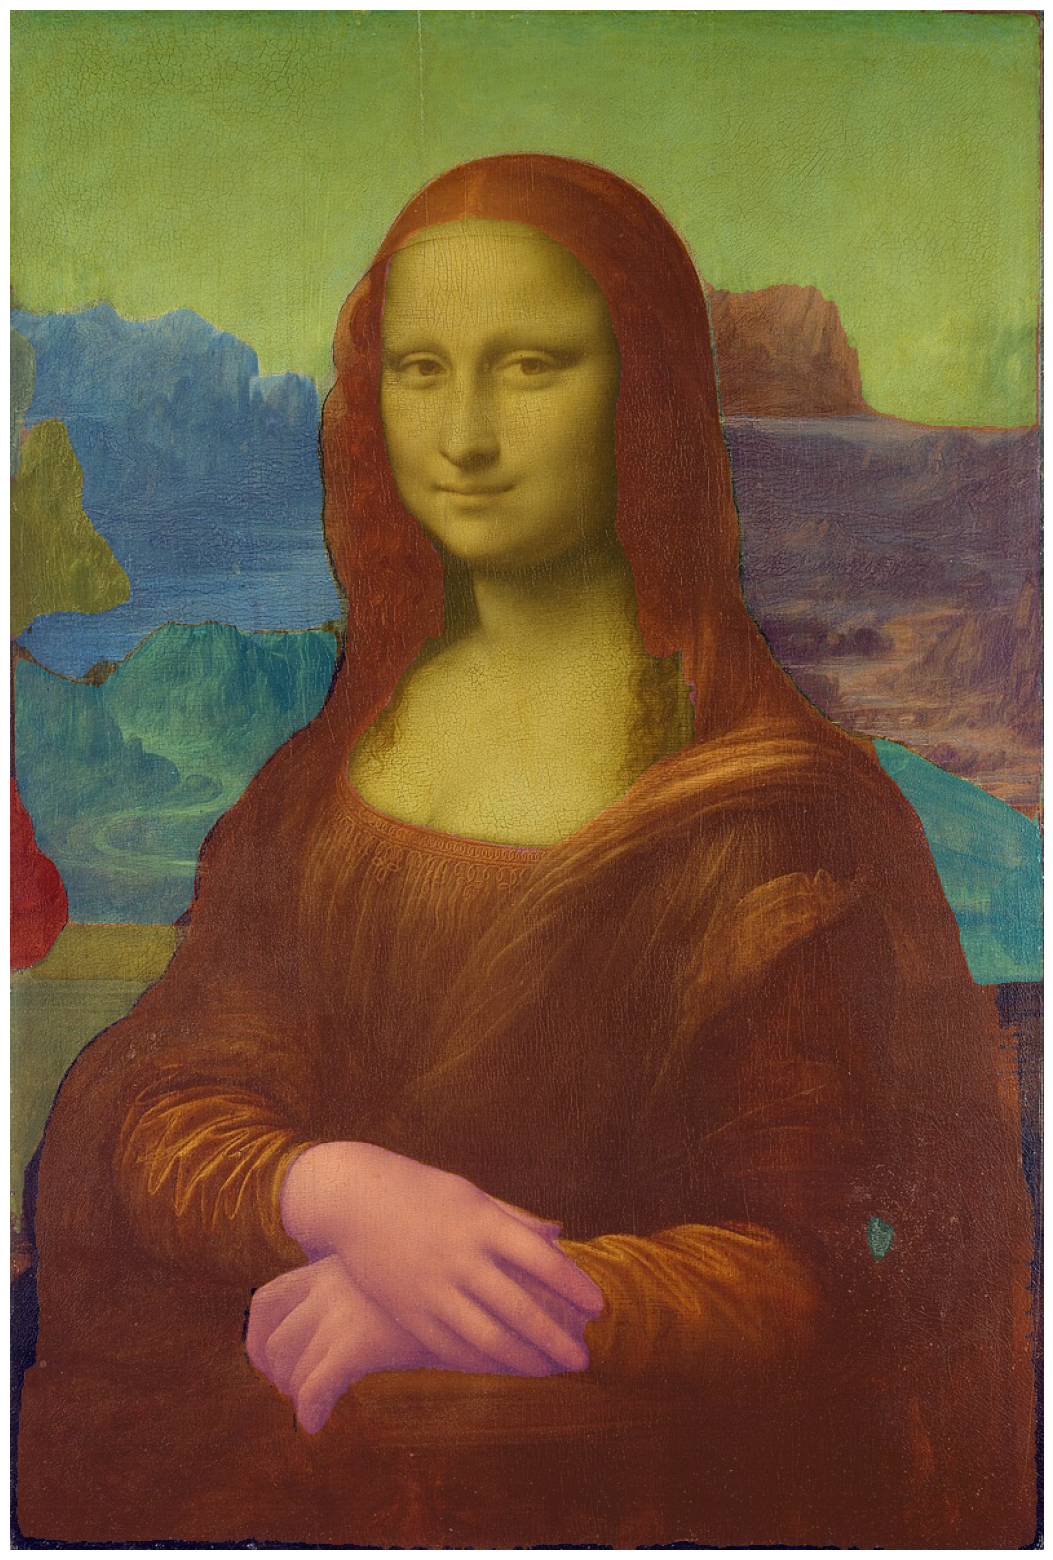

In [99]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 